<h1 align="center"> Tests für eigene Stonesoup Jupyter Notebooks </h1>
<h3 align="center"> Probieren und testen von Ideen </h3>

In [61]:
%matplotlib qt

from datetime import timedelta
from datetime import datetime

import numpy as np

<h2 align="center"> Erstellen der Ausgabe </h2>

In [62]:
velocity = 300.0
acceleration = 9.0
omega = acceleration / ( 2 * velocity)
A = (velocity**2) / acceleration

In [63]:
# Figure to plot truth (and future data)
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(10, 6))
ax = figure.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

truth = GroundTruthPath()
start_time = datetime.now()

test = np.linspace(0, (2 * np.pi )/ omega, 100, endpoint = True)

for t in test:
    x = A * np.sin(omega * t)
    y = A * np.sin(2 * omega * t)
    covariance = np.array([[20.05, 0],[0, 20.05]])
    xy = np.random.multivariate_normal(np.array([x,y]), covariance)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]), timestamp=start_time+timedelta(seconds=t)))

ax.plot([state.state_vector[0, 0] for state in truth], 
        [state.state_vector[1, 0] for state in truth], 
        linestyle="--", color="grey")

Groundtruth erstellt, jetzt Messungen generieren.

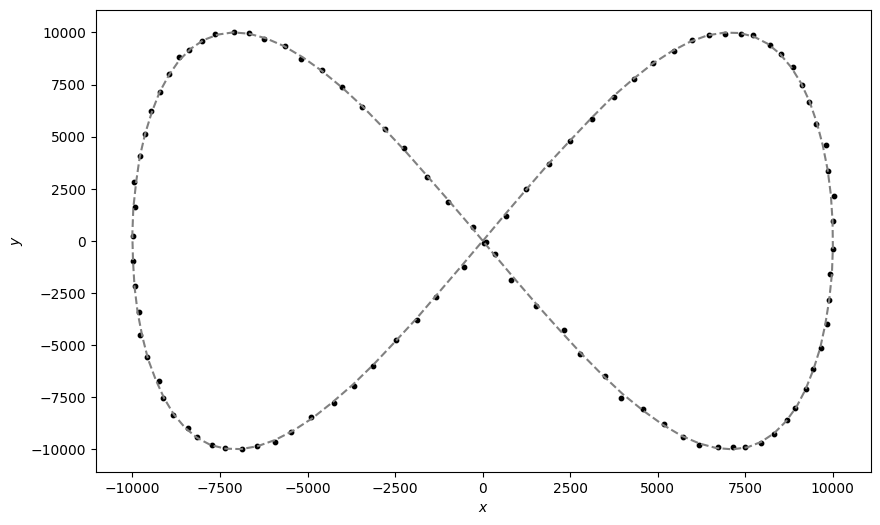

In [64]:
from scipy.stats import multivariate_normal
from stonesoup.types.detection import Detection

measurements = []
for state in truth:
    xOffset = 50 * np.random.normal(0, 1, 1)
    yOffset = 50 * np.random.normal(0, 1, 1)
    x, y = multivariate_normal.rvs(
        state.state_vector.ravel(), cov=np.diag([0.5, 0.5]))
    measurements.append(Detection(
        np.array([[x] + xOffset, [y] + yOffset]), timestamp=state.timestamp))
    
# Plot the result
ax.scatter([state.state_vector[0, 0] for state in measurements], 
           [state.state_vector[1, 0] for state in measurements], 
           color='black', s = 10)
figure

Transitionsmodell erstellen
----------------------------
Transitionsmatrix $F$ und Prozessrauschen $Q$ erstellen

In [65]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.05), ConstantVelocity(0.05)))

In [66]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [67]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.01666667, 0.025     , 0.        , 0.        ],
       [0.025     , 0.05      , 0.        , 0.        ],
       [0.        , 0.        , 0.01666667, 0.025     ],
       [0.        , 0.        , 0.025     , 0.05      ]])

Predictor-Komponente programmieren um $x_{k|k-1}$ zu bekommen

In [68]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

Next we'll create our model which will describe errors of measuring in the observable state, and how the hidden state maps to observable state. In this case we can simply map the $x$ and $y$ directly.

In [69]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    4, # Number of state dimensions (position and velocity in 2D)
    (0,2), # Mapping measurement vector index to state index
    np.array([[0.75, 0],  # Covariance matrix for Gaussian PDF
              [0, 0.75]])
    )

This will give us the observation model $H$ And observation model covariance $R$.

In [70]:
measurement_model.matrix()


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [71]:
measurement_model.covar()

array([[0.75, 0.  ],
       [0.  , 0.75]])

Filter bauen, der anhand einer Messung $x_{k|k}$ berechnet

In [72]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

Kalman-Filter ausführen
-----------------------
Alle Komponenten sind kreiert, jetzt Startzustand wählen

In [73]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([10.5, 0.5, 10.5, 0.5]), timestamp=start_time)

Alle Messungen durchgehen, prädizieren und updaten

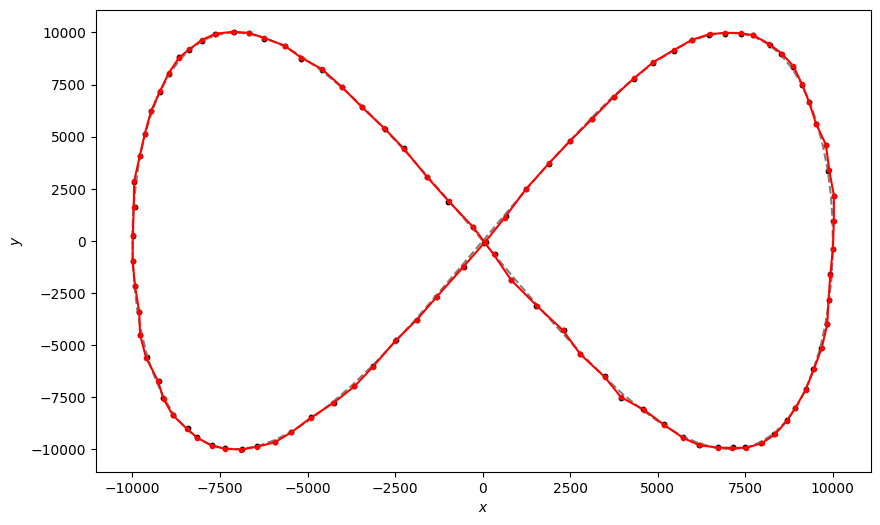

In [74]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement) # Used to group a prediction and measurement together
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

# Plot the resulting track
ax.plot([state.state_vector[0, 0] for state in track], 
        [state.state_vector[2, 0] for state in track],
        marker=".", color = "red")
figure

In [ ]:
from matplotlib.patches import Ellipse
for state in track:
    w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                      width=np.sqrt(w[0])*50, height=np.sqrt(w[1])*50,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)
figure

In [ ]:
from matplotlib.patches import Ellipse
for state in track:
    w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                      width=np.sqrt(w[0])*50, height=np.sqrt(w[1])*50,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)
figure

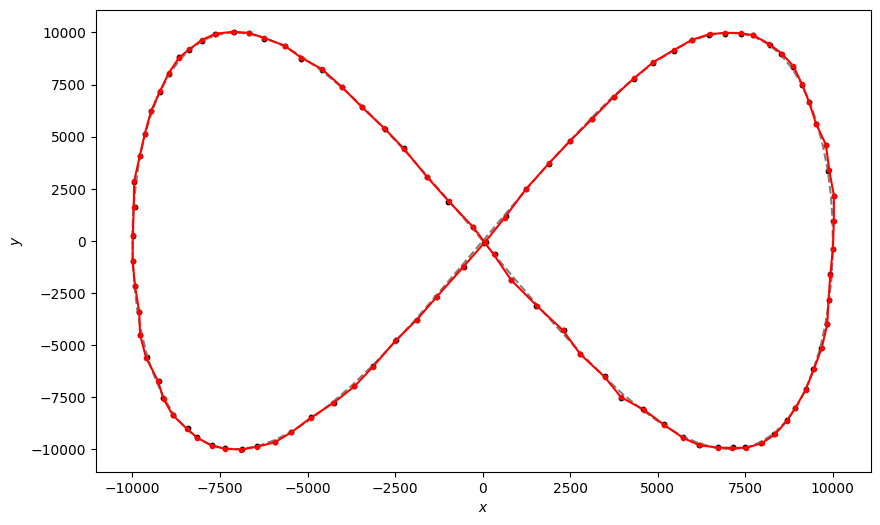

In [75]:
from matplotlib.patches import Ellipse
for state in track:
    w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                      width=np.sqrt(w[0])*50, height=np.sqrt(w[1])*50,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)
figure